In [1]:
cd ..

/Users/ani/Documents/time-series-forecasting


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.tsa.stattools import adfuller,pacf,acf
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import pickle

In [3]:
df_train = pd.read_csv('./data/train.csv', low_memory=False)
df_test = pd.read_csv('./data/test.csv', low_memory=False)

# Transform Date column into datetime format
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [4]:
# from statsmodels.tsa.arima.model import ARIMA
# models_store = {}
# forecasts = []
# for s in range(7):
#     for p in range(10):
#         train_temp = df_train[(df_train['store']==s) & (df_train['product']==p)].copy(deep=True)
#         train_temp = train_temp.set_index('Date')
#         model = ARIMA(train_temp['number_sold'], order=(28, 0, 6))
#         results = model.fit()
#         models_store[f's{s}_p{p}'] = results
#         forecast = results.forecast(steps=364)
#         forecast_df = forecast.reset_index()
#         forecast_df['store'] = s
#         forecast_df['product']=p
#         forecasts.append(forecast_df)

#     print(f'Store {s} Finished training')

# # Print summary
# print(results.summary())


In [5]:
# # Save Models

# for s in range(7):
#     for p in range(10):
#         with open(f"models/model_s{s}_p{p}.pkl", "wb") as f:
#             pickle.dump(models_store[f's{s}_p{p}'], f)
#             print(f's{s}_p{p}')

In [8]:
models = {}

forecasts = []
for s in range(7):
    for p in range(10):
        with open(f"models/model_s{s}_p{p}.pkl", "rb") as f:
            models[f's{s}_p{p}'] = pickle.load(f)
            forecast = models[f's{s}_p{p}'].forecast(steps=364)
            forecast_df = forecast.reset_index()
            forecast_df['store'] = s
            forecast_df['product']=p
            forecasts.append(forecast_df)

In [9]:
df_preds = pd.concat(forecasts).rename(columns={'index':"Date"})
df_comb = df_preds.merge(df_test[['Date', 'store', 'product', 'number_sold']], on = ['Date', 'store', 'product'])

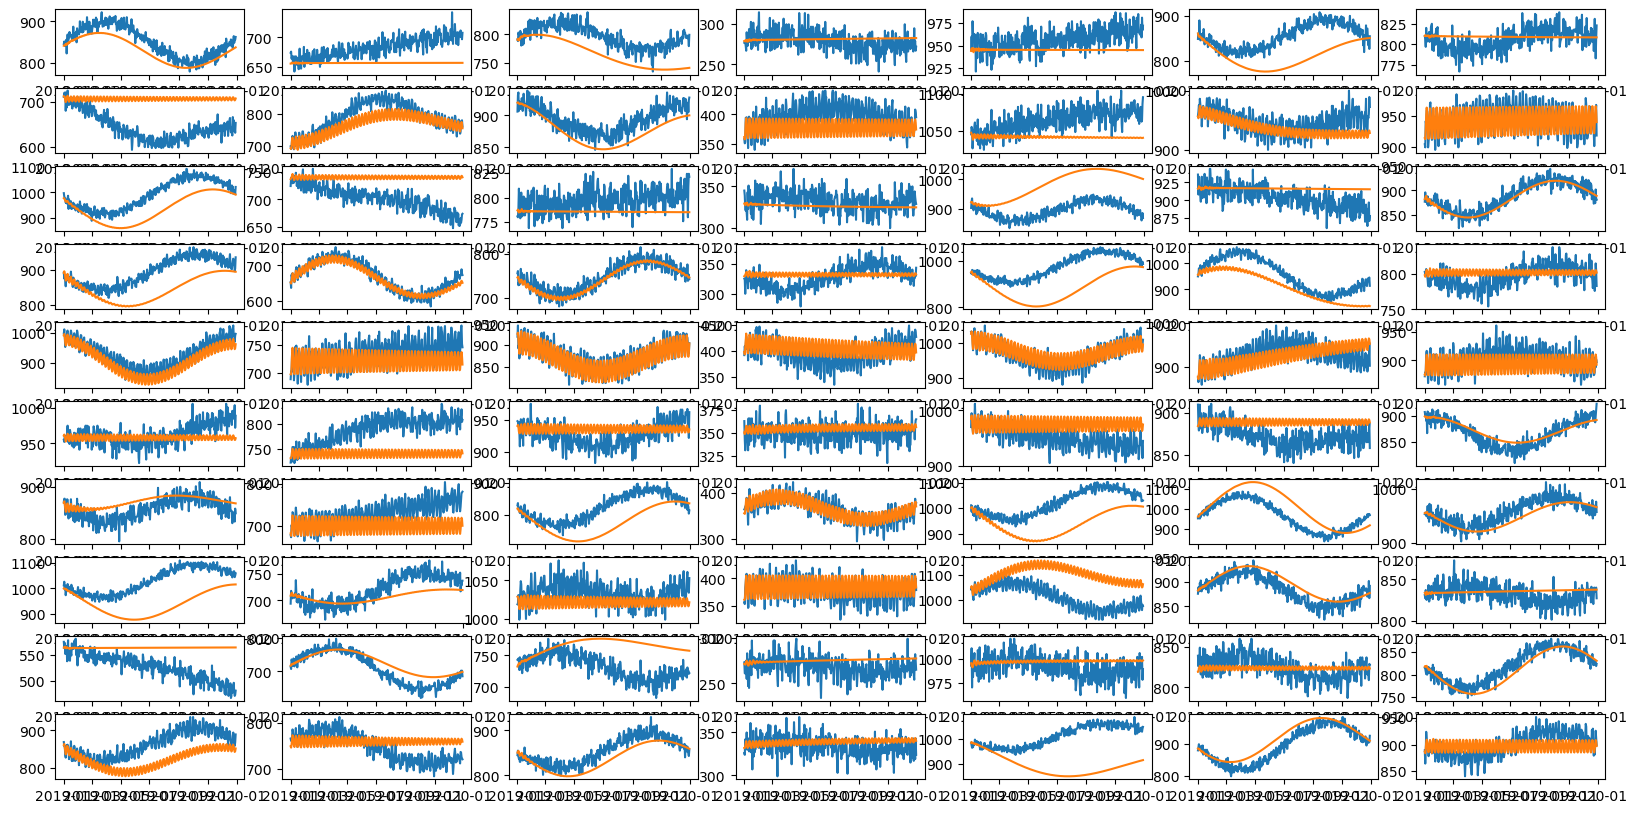

In [10]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))
for s in range(7):
    for p in range(10):
        sns.lineplot(
            x='Date', 
            y = 'number_sold', 
            data = df_comb[(df_comb['product']==p) & (df_comb['store']==s)], 
            label= 'actual', 
            ax=ax[p,s])
        sns.lineplot(x='Date', y = 'predicted_mean', data = df_comb[(df_comb['product']==p) & (df_comb['store']==s)], label = 'forecast', ax=ax[p,s])
        ax[p,s].legend_.remove()
        ax[p,s].set_ylabel('')
        ax[p,s].set_xlabel('')

In [11]:
mean_absolute_percentage_error(df_comb['number_sold'], df_comb['predicted_mean'])

0.03527664753989224

# Fit Residuals from the time series model to a Booster model to adjust predictions for their errors later on

In [12]:
residuals = []
for s in range(7):
    for p in range(10):
        resid = models[f's{s}_p{p}'].resid.reset_index()
        resid['store'] = s
        resid['product'] = p
        residuals.append(resid)

## concatenate all residuals and fit 1 model for all of them 

In [ ]:
df_resid = pd.concat(residuals).rename(columns={0:'resid'})

In [ ]:
# Feature engineering

df_resid['month'] = df_resid['Date'].dt.month
df_resid['year'] = df_resid['Date'].dt.year
df_resid['day_of_week'] = df_resid['Date'].dt.day_of_week
df_resid['day_of_month'] = df_resid['Date'].dt.day
df_resid = df_resid.sort_values(by=['store', 'product', 'Date'])
for i in range(1,14):
    df_resid[f'y_lag_{i}'] = df_resid.groupby(['store', 'product'])['resid'].shift(i)

/var/folders/k1/73gwskx154d7kvz9pjlpj_q00000gn/T/ipykernel_34144/3980476835.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_resid[f'y_lag_{i}'] = df_resid.groupby(['store', 'product'])['resid'].shift(i)
/var/folders/k1/73gwskx154d7kvz9pjlpj_q00000gn/T/ipykernel_34144/3980476835.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_resid[f'y_lag_{i}'] = df_resid.groupby(['store', 'product'])['resid'].shift(i)
/var/folders/k1/73gwskx154d7kvz9pjlpj_q00000gn/T/ipykernel_34144/3980476835.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pand

In [156]:
target = 'resid'
cat_features = ['store', 'product']
lag_cols = [x for x in df_resid.columns if 'lag' in x]
features = ['day_of_month', 'day_of_week']+ lag_cols + cat_features
df_resid[cat_features] = df_resid[cat_features].astype('category')

In [ ]:
# Transform into lightgbm Dataset so that we can use lightgbm model for training
import lightgbm as lgb
df_train_temp = df_resid[df_resid['year']<2018][features + [target]].copy()
df_valid_temp = df_resid[df_resid['year']==2018][features + [target]].copy()
lgb_train = lgb.Dataset(df_train_temp.drop(columns=[target]), label=df_train_temp[target])
lgb_valid = lgb.Dataset(df_valid_temp.drop(columns=[target]), label=df_valid_temp[target])

In [ ]:
from lightgbm import LGBMRegressor

# default parameters
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'learning_rate': "0.01",
    'num_leaves': "31",
    'subsample': "0.8",
    'colsample_bytree': "0.8",
    'reg_alpha': "0.1",
    'reg_lambda': "0.1",
    'seed': "42",
}
# first we fit the model with the valid set of year 2018 from training step so that we can find the number of rounds to train
# Then we use all training data to train the model until the best iteration of the first model 
first_model = lgb.train(
    params = params,
    train_set = lgb_train, 
    valid_sets=[lgb_valid],
    num_boost_round=20000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=300),
        lgb.log_evaluation(period=200)
        ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 204540, number of used features: 17
[LightGBM] [Info] Start training from score -0.034037
Training until validation scores don't improve for 300 rounds
[200]	valid_0's l2: 109.518
[400]	valid_0's l2: 109.473
[600]	valid_0's l2: 109.471
[800]	valid_0's l2: 109.476
Early stopping, best iteration is:
[594]	valid_0's l2: 109.468


In [ ]:
# Train the model with all training Data
lgb_train_final = lgb.Dataset(df_resid[features + [target]].drop(columns=[target]), label=df_resid[target])
model_final = lgb.train(
    params = params,
    train_set = lgb_train_final, 
    num_boost_round=first_model.best_iteration,
    callbacks=[
        lgb.log_evaluation(period=10)
        ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 230090, number of used features: 18
[LightGBM] [Info] Start training from score -0.001329


In [ ]:
df_test_new = df_test.copy()
df_test_new['day_of_month'] = df_test_new['Date'].dt.day
df_test_new['day_of_week'] = df_test_new['Date'].dt.isocalendar()['week']
df_test_new['month'] = df_test_new['Date'].dt.month

In [ ]:
# Since we cannot use data in the test set, we will use predictions 
# generated each day to feed them as lagged variables (y_lag_1, ...)

def func_roll_over(df_pred_old, df_test_new, df_train, dt):
    df_temp = pd.concat([df_test_new[df_test_new['Date'].astype('str')==dt], df_train, df_pred_old])
    df_temp.sort_values(by=['store', 'product', 'Date'], inplace=True)
    for i in range(1,7):
        df_temp[f'y_lag_{i}'] = df_temp.groupby(['store', 'product'])['resid'].shift(i)
    pred_df = df_temp[df_temp['Date'].astype('str')==dt][features]
    pred_df[cat_features] = pred_df[cat_features].astype('category')
    pred_df['resid'] = first_model.predict(pred_df[features])
    pred_df['Date'] = pd.to_datetime(dt)
    return pred_df

In [ ]:
# generate predictions of residuals for the whole year
preds = []
pred_old = pd.DataFrame()
i = 1
for dt in sorted(df_test['Date'].astype('str').unique()):
    pred_old = func_roll_over(pred_old, df_test_new, df_resid, dt)
    preds.append(pred_old)
    if i> 1:
        pred_old = pd.concat(preds)
    i+=1

<Axes: >

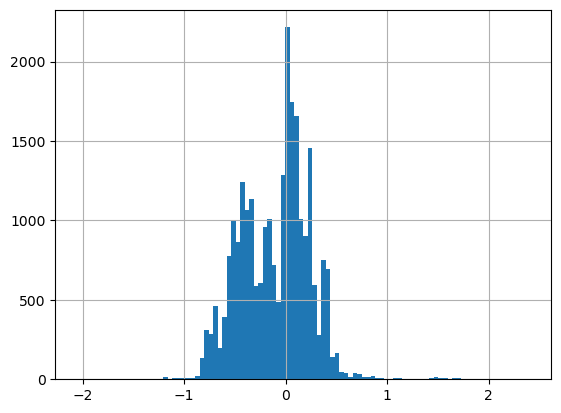

In [171]:
# histogram of the predictions by the model 
preds_daily = pd.concat(preds)
preds_daily['resid'].hist(bins=100)

From the plot, the model does a poor job predicting residuals. 

# Combine Predictions

In [172]:
final_preds= preds_daily.merge(
    df_comb[['store', 'product', 'Date', 'predicted_mean', 'number_sold']],
    on =['store', 'product', 'Date'],
    how='left'
    )
final_preds = final_preds[~final_preds['predicted_mean'].isna()]

final_preds['final_pred'] = (final_preds['resid'] + final_preds['predicted_mean']).apply(lambda x: int(x))

In [173]:
mean_absolute_percentage_error(final_preds['number_sold'], final_preds['final_pred'])

0.03540876840060815